# ANALISIS INICIAL DE LOS DATOS

In [67]:
# Importamos librerias necesarias
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from plotly.subplots import make_subplots
import requests
import io

In [68]:
# Para poder abrir los archivos con la url
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [69]:
# Cargamos el dataset de listing pero en formato gz, tambien el data de review y el data de listing pero solo CSV
df_listings = pd.read_csv('https://data.insideairbnb.com/spain/catalonia/barcelona/2024-03-20/data/listings.csv.gz')
df_neighbourhoods = pd.read_csv(r'https://data.insideairbnb.com/spain/catalonia/barcelona/2024-03-20/visualisations/neighbourhoods.csv')
df_reviews = pd.read_csv (r'https://data.insideairbnb.com/spain/catalonia/barcelona/2024-03-20/data/reviews.csv.gz')
df_calendar = pd.read_csv(r'https://data.insideairbnb.com/spain/catalonia/barcelona/2024-03-20/data/calendar.csv.gz')

# la url de la página es la siguiente: https://insideairbnb.com/get-the-data/

/var/folders/qz/_32xyxhj33x5fkccrdmk10580000gn/T/ipykernel_34793/2027385552.py:5: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_calendar = pd.read_csv(r'https://data.insideairbnb.com/spain/catalonia/barcelona/2024-03-20/data/calendar.csv.gz')


In [70]:
# Mostrar todas las columnas y filas de nuestro dataframes
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Configuración del formato de numeros
pd.options.display.float_format = '{:.2f}'.format

In [71]:
# Hacemos una copia de los dataframe antes de eliminar o modificar los datos

df_listings_copy = df_listings.copy()
df_neighbourhoods_copy = df_neighbourhoods.copy()
df_reviews_copy = df_reviews.copy()
df_calendar_copy = df_calendar.copy()

# **LIMPIEZA DATAFRAMES**
Disponemos de los siguientes dataframe:
- df_calendar
- df_reviews
- df_neighbourhoods
- df_listings

### **DF_CALENDAR**

In [72]:
df_calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,97529,2024-03-20,f,$47.00,NaN,120,1125
1,360863,2024-03-20,f,$50.00,NaN,31,150
2,360863,2024-03-21,f,$50.00,NaN,31,150
3,360863,2024-03-22,f,$50.00,NaN,31,150
4,360863,2024-03-23,f,$50.00,NaN,31,150


In [73]:
df_calendar.shape

(6759363, 7)

In [74]:
df_calendar.isnull().sum()

listing_id              0
date                    0
available               0
price                   0
adjusted_price    6758633
minimum_nights          0
maximum_nights          0
dtype: int64

In [75]:
# Convertimos columna 'price' de tipo objeto a tipo numérico flotante.
df_calendar['price'] = df_calendar['price'].str.replace('[^\d.]', '', regex=True).astype(float)

Podemos ver que tenemos casi todos los valores nulos dentro de al columna 'adjusted_price', por lo que eliminaremos la columna.

In [76]:
# Eliminamos la columna
df_calendar.drop(['adjusted_price'], axis=1,inplace=True)

In [77]:
df_calendar.isnull().sum()

listing_id        0
date              0
available         0
price             0
minimum_nights    0
maximum_nights    0
dtype: int64

Ya no tenemos valores nulos dentro de calendar, por lo que podemos utilizarlo para nuestro analisis

### **DF_NEIGHBOURHOODS**

In [78]:
df_neighbourhoods.head()

,neighbourhood_group,neighbourhood
0,Ciutat Vella,el Barri Gòtic
1,Ciutat Vella,el Raval
2,Ciutat Vella,la Barceloneta
3,Ciutat Vella,"Sant Pere, Santa Caterina i la Ribera"
4,Eixample,el Fort Pienc


In [79]:
df_neighbourhoods.isnull().sum()

neighbourhood_group    0
neighbourhood          0
dtype: int64

No tenemos valores nulos dentro del dataframe neighbourhoods  por lo tanto podemos utilizarlo para nuestro analisis.

In [80]:
df_neighbourhoods['neighbourhood_group'].unique()

array(['Ciutat Vella', 'Eixample', 'Gràcia', 'Horta-Guinardó',
       'Les Corts', 'Nou Barris', 'Sant Andreu', 'Sant Martí',
       'Sants-Montjuïc', 'Sarrià-Sant Gervasi'], dtype=object)

Dataframe neighbourghood no será utilizado en nuestro analisis, por lo tanto, podemos prescindir del dataframes.

### **DF_REVIEWS**

In [81]:
df_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,360863,1124282,2012-04-13,1853183,Anna,We stayed at Humberto's apartment for 9 days ...
1,17475,63134,2010-07-10,141807,Zoltan,"Excellent host, beautiful apartment, great loc..."
2,17475,83802,2010-08-24,68687,John,"Luca is very personable, and the views are exa..."
3,17475,98998,2010-09-17,96055,Xiaoyang,I am glad we found Luca's apt for our stay in ...
4,17475,105280,2010-09-26,171084,Amy,I should start by saying we really did not wan...


In [82]:
df_reviews.isnull().sum()

listing_id        0
id                0
date              0
reviewer_id       0
reviewer_name     0
comments         75
dtype: int64

In [83]:
df_reviews.isnull().sum()/len(df_reviews)*100

listing_id      0.00
id              0.00
date            0.00
reviewer_id     0.00
reviewer_name   0.00
comments        0.01
dtype: float64

Como solo tenemos 67 comentarios como valores nulos, y representan un 0,01 % de la data, eleminares esas filas para poder tener el dataframe sin valores nulos.

In [84]:
df_reviews.dropna(subset=['comments'], inplace=True)

In [85]:
# Comprobamos si tenemos valores nulos
df_reviews.isnull().sum()

listing_id       0
id               0
date             0
reviewer_id      0
reviewer_name    0
comments         0
dtype: int64

Como podemos ver, ya no tenemos valores nulos dentro de nuestro dataframe df_reviews

### **DF_LISTINGS**

In [86]:
df_listings.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,360863,https://www.airbnb.com/rooms/360863,20240320024717,2024-03-20,previous scrape,SPECIAL OFFER @ COSY AND CHARMING,Fully furnished and renovated apartment in the...,The Barceloneta is a triangular spit of land t...,https://a0.muscache.com/pictures/4378248/3e40f...,1824328,https://www.airbnb.com/users/show/1824328,Umberto,2012-02-28,"Barcelona, Spain",I am passionate about traveling and discoverin...,NaN,NaN,57%,t,https://a0.muscache.com/im/users/1824328/profi...,https://a0.muscache.com/im/users/1824328/profi...,La Barceloneta,2.00,4.00,"['email', 'phone']",t,f,"Barcelona, Catalonia, Spain",la Barceloneta,Ciutat Vella,41.38,2.20,Private room in rental unit,Private room,2,NaN,1 private bath,NaN,NaN,"[""Cleaning available during stay"", ""Baking she...",NaN,31,150,31,31,150,150,31.00,150.00,NaN,NaN,0,0,0,0,2024-03-20,32,0,0,2012-04-13,2015-10-21,4.73,4.84,4.84,4.91,4.94,4.71,4.74,NaN,f,2,1,1,0,0.22
1,17475,https://www.airbnb.com/rooms/17475,20240320024717,2024-03-20,city scrape,Attic Sagrada Familia,Beautiful attic apartment <br />with large ter...,NaN,https://a0.muscache.com/pictures/f6e6718f-dba0...,65623,https://www.airbnb.com/users/show/65623,Luca,2009-12-25,"Rome, Italy",Italian.,within a few hours,100%,82%,f,https://a0.muscache.com/im/pictures/user/989d6...,https://a0.muscache.com/im/pictures/user/989d6...,Dreta de l'Eixample,2.00,6.00,"['email', 'phone']",t,t,NaN,la Dreta de l'Eixample,Eixample,41.40,2.17,Entire rental unit,Entire home/apt,3,1.00,1 bath,1.00,1.00,"[""Microwave"", ""Outdoor dining area"", ""Private ...",$165.00,3,90,3,3,90,90,3.00,90.00,NaN,t,0,0,0,7,2024-03-20,29,12,1,2010-07-10,2024-03-01,4.48,4.73,4.23,4.82,4.73,4.82,4.50,NaN,f,1,1,0,0,0.17
2,18674,https://www.airbnb.com/rooms/18674,20240320024717,2024-03-20,city scrape,Huge flat for 8 people close to Sagrada Familia,110m2 apartment to rent in Barcelona. Located ...,Apartment in Barcelona located in the heart of...,https://a0.muscache.com/pictures/13031453/413c...,71615,https://www.airbnb.com/users/show/71615,Mireia Maria,2010-01-19,"Barcelona, Spain","We are Mireia (47) & Maria (49), two multiling...",within an hour,97%,85%,f,https://a0.muscache.com/im/pictures/user/User-...,https://a0.muscache.com/im/pictures/user/User-...,la Sagrada Família,44.00,46.00,"['email', 'phone']",t,t,"Barcelona, CT, Spain",la Sagrada Família,Eixample,41.41,2.17,Entire rental unit,Entire home/apt,8,2.00,2 baths,3.00,6.00,"[""Paid parking on premises"", ""Private patio or...",$210.00,1,1125,1,4,1125,1125,2.90,1125.00,NaN,t,18,41,63,252,2024-03-20,40,6,0,2013-05-27,2023-11-07,4.33,4.44,4.62,4.74,4.67,4.77,4.28,HUTB-002062,t,28,28,0,0,0.30
3,97529,https://www.airbnb.com/roo

In [87]:
# Vemos las columnas del dataframe
df_listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [88]:
# Las columnas que vamos a tener en cuenta para nuestro estudio son las siguientes:
target_columns = [
    'id', 'listing_url', 'name', 'neighbourhood_cleansed','neighbourhood_group_cleansed', 'property_type', 'room_type', 'latitude', 'longitude',
    'price', 'minimum_nights', 'maximum_nights', 'accommodates', 'bedrooms', 'beds', 'bathrooms', 'amenities',
    'number_of_reviews', 'number_of_reviews_ltm', 'reviews_per_month', 'review_scores_rating', 'review_scores_cleanliness',
    'review_scores_communication', 'review_scores_location', 'review_scores_value', 'host_is_superhost', 'host_response_rate',
    'host_listings_count','availability_365', 'calculated_host_listings_count'
]


# Creamos un nuevo dataframe con las columnas objetivo
df_listings = df_listings[target_columns]
df_listings.head()

,id,listing_url,name,neighbourhood_cleansed,neighbourhood_group_cleansed,property_type,room_type,latitude,longitude,price,minimum_nights,maximum_nights,accommodates,bedrooms,beds,bathrooms,amenities,number_of_reviews,number_of_reviews_ltm,reviews_per_month,review_scores_rating,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_value,host_is_superhost,host_response_rate,host_listings_count,availability_365,calculated_host_listings_count
0,360863,https://www.airbnb.com/rooms/360863,SPECIAL OFFER @ COSY AND CHARMING,la Barceloneta,Ciutat Vella,Private room in rental unit,Private room,41.38,2.20,NaN,31,150,2,NaN,NaN,NaN,"[""Cleaning available during stay"", ""Baking she...",32,0,0.22,4.73,4.84,4.94,4.71,4.74,t,NaN,2.00,0,2
1,17475,https://www.airbnb.com/rooms/17475,Attic Sagrada Familia,la Dreta de l'Eixample,Eixample,Entire rental unit,Entire home/apt,41.40,2.17,$165.00,3,90,3,1.00,1.00,1.00,"[""Microwave"", ""Outdoor dining area"", ""Private ...",29,12,0.17,4.48,4.23,4.73,4.82,4.50,f,100%,2.00,7,1
2,18674,https://www.airbnb.com/rooms/18674,Huge flat for 8 people close to Sagrada Familia,la Sagrada Família,Eixample,Entire rental unit,Entire home/apt,41.41,2.17,$210.00,1,1125,8,3.00,6.00,2.00,"[""Paid parking on premises"", ""Private patio or...",40,6,0.30,4.33,4.62,4.67,4.77,4.28,f,97%,44.00,252,28
3,97529,https://www.airbnb.com/rooms/97529,Furnished one bedroom apartment with bathroom,el Camp d'en Grassot i Gràcia Nova,Gràcia,Entire rental unit,Entire home/apt,41.41,2.17,NaN,120,1125,2,1.00,NaN,NaN,"[""Microwave"", ""Paid parking off premises"", ""Pr...",67,0,0.45,4.74,4.86,4.91,4.45,4.71,f,NaN,1.00,0,1
4,110041,https://www.airbnb.com/rooms/110041,002. Alió 2 Apartment,el Camp d'en Grassot i Gràcia Nova,Gràcia,Entire rental unit,Entire home/apt,41.40,2.17,$94.00,1,1125,4,1.00,2.00,1.00,"[""Microwave"", ""Iron"", ""Dedicated workspace"", ""...",54,18,0.38,4.17,4.24,4.41,4.65,4.11,f,100%,114.00,226,95


In [89]:
df_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18519 entries, 0 to 18518
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              18519 non-null  int64  
 1   listing_url                     18519 non-null  object 
 2   name                            18519 non-null  object 
 3   neighbourhood_cleansed          18519 non-null  object 
 4   neighbourhood_group_cleansed    18519 non-null  object 
 5   property_type                   18519 non-null  object 
 6   room_type                       18519 non-null  object 
 7   latitude                        18519 non-null  float64
 8   longitude                       18519 non-null  float64
 9   price                           14656 non-null  object 
 10  minimum_nights                  18519 non-null  int64  
 11  maximum_nights                  18519 non-null  int64  
 12  accommodates                    

In [90]:
# Convertimos columna 'price' de tipo objeto a tipo numérico flotante.
df_listings['price'] = df_listings['price'].str.replace('[^\d.]', '', regex=True).astype(float)

In [91]:
df_listings.isnull().sum()

id                                   0
listing_url                          0
name                                 0
neighbourhood_cleansed               0
neighbourhood_group_cleansed         0
property_type                        0
room_type                            0
latitude                             0
longitude                            0
price                             3863
minimum_nights                       0
maximum_nights                       0
accommodates                         0
bedrooms                          2000
beds                              3930
bathrooms                         3851
amenities                            0
number_of_reviews                    0
number_of_reviews_ltm                0
reviews_per_month                 4757
review_scores_rating              4756
review_scores_cleanliness         4758
review_scores_communication       4757
review_scores_location            4761
review_scores_value               4761
host_is_superhost        

<Axes: >

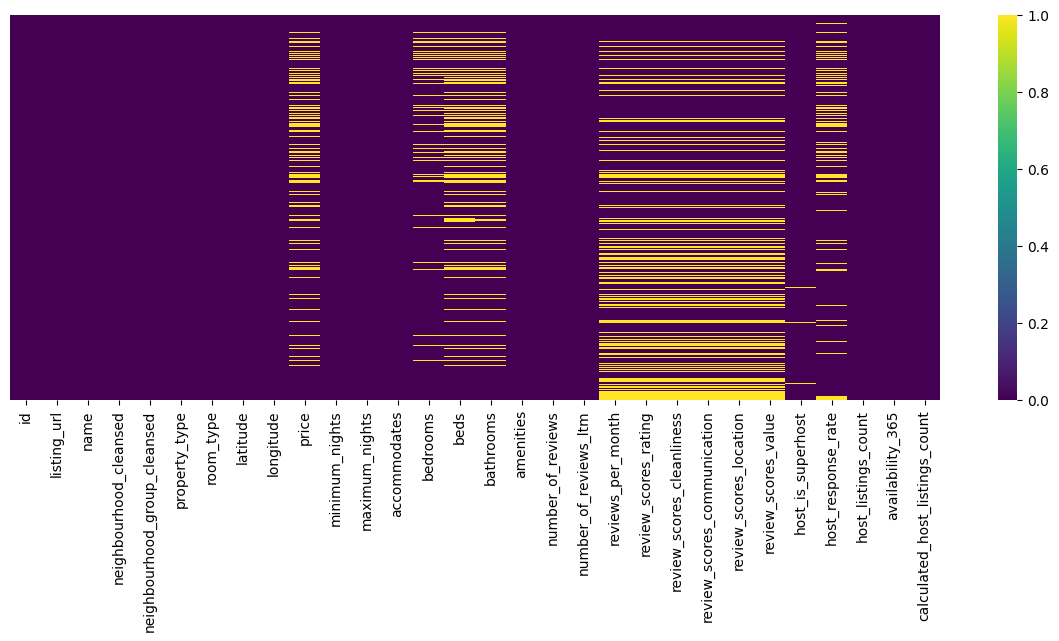

In [92]:
# Graficamos los valores nulos
plt.figure(figsize=(15, 5))
sns.heatmap(df_listings.isnull(), yticklabels=False, cbar=True, cmap="viridis")

In [93]:
df_listings.head()

,id,listing_url,name,neighbourhood_cleansed,neighbourhood_group_cleansed,property_type,room_type,latitude,longitude,price,minimum_nights,maximum_nights,accommodates,bedrooms,beds,bathrooms,amenities,number_of_reviews,number_of_reviews_ltm,reviews_per_month,review_scores_rating,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_value,host_is_superhost,host_response_rate,host_listings_count,availability_365,calculated_host_listings_count
0,360863,https://www.airbnb.com/rooms/360863,SPECIAL OFFER @ COSY AND CHARMING,la Barceloneta,Ciutat Vella,Private room in rental unit,Private room,41.38,2.20,NaN,31,150,2,NaN,NaN,NaN,"[""Cleaning available during stay"", ""Baking she...",32,0,0.22,4.73,4.84,4.94,4.71,4.74,t,NaN,2.00,0,2
1,17475,https://www.airbnb.com/rooms/17475,Attic Sagrada Familia,la Dreta de l'Eixample,Eixample,Entire rental unit,Entire home/apt,41.40,2.17,165.00,3,90,3,1.00,1.00,1.00,"[""Microwave"", ""Outdoor dining area"", ""Private ...",29,12,0.17,4.48,4.23,4.73,4.82,4.50,f,100%,2.00,7,1
2,18674,https://www.airbnb.com/rooms/18674,Huge flat for 8 people close to Sagrada Familia,la Sagrada Família,Eixample,Entire rental unit,Entire home/apt,41.41,2.17,210.00,1,1125,8,3.00,6.00,2.00,"[""Paid parking on premises"", ""Private patio or...",40,6,0.30,4.33,4.62,4.67,4.77,4.28,f,97%,44.00,252,28
3,97529,https://www.airbnb.com/rooms/97529,Furnished one bedroom apartment with bathroom,el Camp d'en Grassot i Gràcia Nova,Gràcia,Entire rental unit,Entire home/apt,41.41,2.17,NaN,120,1125,2,1.00,NaN,NaN,"[""Microwave"", ""Paid parking off premises"", ""Pr...",67,0,0.45,4.74,4.86,4.91,4.45,4.71,f,NaN,1.00,0,1
4,110041,https://www.airbnb.com/rooms/110041,002. Alió 2 Apartment,el Camp d'en Grassot i Gràcia Nova,Gràcia,Entire rental unit,Entire home/apt,41.40,2.17,94.00,1,1125,4,1.00,2.00,1.00,"[""Microwave"", ""Iron"", ""Dedicated workspace"", ""...",54,18,0.38,4.17,4.24,4.41,4.65,4.11,f,100%,114.00,226,95


#### CORRECCION DATOS CON KNN

In [94]:
# Comprobamos que no tenemos duplicados
df_listings.duplicated().sum()

0

In [95]:
df_listings.columns

Index(['id', 'listing_url', 'name', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'property_type', 'room_type',
       'latitude', 'longitude', 'price', 'minimum_nights', 'maximum_nights',
       'accommodates', 'bedrooms', 'beds', 'bathrooms', 'amenities',
       'number_of_reviews', 'number_of_reviews_ltm', 'reviews_per_month',
       'review_scores_rating', 'review_scores_cleanliness',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'host_is_superhost', 'host_response_rate',
       'host_listings_count', 'availability_365',
       'calculated_host_listings_count'],
      dtype='object')

In [96]:
# FUNCION GENERICA CODIFICAR COLUMNAS CATEGORIAS
"""
Esta función se encarga de codificar todas las columnas categóricas (de tipo object)
en un DataFrame utilizando codificación por etiquetas (Label Encoding
"""
def CODIFICAR_CATEGORICAS(df):
    """
    Given a pandas DataFrame, encodes all categorical (object) columns using
    Label Encoding and returns a copy of the encoded DataFrame.
    Parameters:
    - df: pandas DataFrame
    Returns:
    - df_encoded: pandas DataFrame
    """
    df_encoded = df.copy()  # Make a copy of the original DataFrame
    # Select the categorical columns of the DataFrame
    object_columns = df_encoded.select_dtypes(include=["object"]).columns
    encoder_info = []  # Initialize a list to store the encoder information

    for column in object_columns:
        # Convert the column to a categorical type
        df_encoded[column] = pd.Categorical(df_encoded[column])

        # Get the codes and categories
        df_encoded[column] = df_encoded[column].cat.codes

        # Replace -1 with NaN to handle missing values
        df_encoded[column] = df_encoded[column].replace(-1, np.nan)

        encoder_info.append(
            {  # Store the encoder information in a dictionary
                "column": column,
                "labels": list(df[column].astype('category').cat.categories),  # List the original labels
                "codes": list(range(len(df[column].astype('category').cat.categories))),  # List the encoded codes
            }
        )

    # Return the encoded DataFrame and the encoder information
    return df_encoded, encoder_info

In [97]:
# Aplicamos la función sobre nuestro dataframe
df_encoded, encoded_info = CODIFICAR_CATEGORICAS (df_listings)

In [98]:
# FUNCIÓN GENERICA ENTRAR MEJOR K PARA KNN

"""
Esta función realiza una regresión con k-vecinos más cercanos (K-NN) usando
validación cruzada para encontrar el mejor valor de k (número de vecinos)
basado en el error cuadrático medio.
"""

def BEST_K(df, target_column, min_k=2, max_k=15):
    """
    Given a pandas DataFrame, a target column name, a range of k values and a
    minimum number of samples per fold, performs K-NN regression using cross-validation
    to find the best value of k (number of neighbors) based on the mean squared error.
    Parameters:
    - df: pandas DataFrame
    - target_column: str, name of the target column
    - min_k: int, minimum number of neighbors to consider
    - max_k: int, maximum number of neighbors to consider
    Returns:
    - best_k: int, best value of k found
    """
    # Instantiate a LabelEncoder object
    le = LabelEncoder()
    # Make a copy of the input DataFrame
    df_encoded = df.copy()
    # Select object columns (categorical) of df_encoded
    object_columns = df_encoded.select_dtypes(include=["object"]).columns
    # Iterate over each categorical column and apply Label Encoding
    for column in object_columns:
        df_encoded[column] = le.fit_transform(df_encoded[column].astype(str))
    # Impute missing values using the mean of each column
    imputer = SimpleImputer(strategy="mean")
    df_imputed = pd.DataFrame(
        imputer.fit_transform(df_encoded), columns=df_encoded.columns
    )
    # Separate the predictors (X) from the target (y)
    X = df_imputed.drop(target_column, axis=1)
    y = df_imputed[target_column]
    # Define a pipeline for K-NN regression
    pipeline = Pipeline(steps=[("model", KNeighborsRegressor(n_neighbors=3))])
    # Set the hyperparameters to tune
    params = {
        "model__n_neighbors": [3, 5, 7],
        "model__weights": ["uniform", "distance"],
    }
    best_k = 0
    best_score = -np.inf
    # Iterate over a range of k values and perform cross-validation
    for k in range(min_k, max_k + 1):
        kf = KFold(n_splits=k, shuffle=True, random_state=42)
        grid_search = GridSearchCV(
            pipeline, params, cv=kf, scoring="neg_mean_squared_error", n_jobs=-1
        )
        grid_search.fit(X, y)
        # Keep track of the best k and best score found so far
        if grid_search.best_score_ > best_score:
            best_score = grid_search.best_score_
            best_k = k
    # Return the best value of k found
    return best_k

In [99]:
# Fijamos la columna objetivo
target_column = 'price'

# Llamamos a la función para encontrar el mejor K
bestkar= BEST_K(df_encoded,target_column)

bestkar

11

In [100]:
# FUNCION GENERICA IMPUTA VALORES FALTANTES DE DF CON KNN

"""
Esta función imputa los valores faltantes en un DataFrame
utilizando un imputador K-NN (KNN Imputer).
"""

def IMPUTAR_BEST_K_DF(df, n_neighbors):
    """
    Impute missing values in a DataFrame using KNN imputer.

    Parameters:
    - df: pandas DataFrame with numerical and encoded categorical columns
    - n_neighbors: int, number of neighbors to use for KNN imputation

    Returns:
    - df_imputed: pandas DataFrame with missing values imputed
    """
    df_imputed = df.copy()

    # Replace -1 with NaN before imputing
    df_imputed.replace(-1, np.nan, inplace=True)

    imputer = KNNImputer(n_neighbors=n_neighbors)
    df_imputed[df_imputed.columns] = imputer.fit_transform(df_imputed)

    return df_imputed


In [101]:
# Llamamos a la función impute_missing_value_with_knn
df_imputed = IMPUTAR_BEST_K_DF(df_encoded, bestkar)

In [102]:
# Comprobamos si tenemos valores nulos
df_imputed.isnull().sum()

id                                0
listing_url                       0
name                              0
neighbourhood_cleansed            0
neighbourhood_group_cleansed      0
property_type                     0
room_type                         0
latitude                          0
longitude                         0
price                             0
minimum_nights                    0
maximum_nights                    0
accommodates                      0
bedrooms                          0
beds                              0
bathrooms                         0
amenities                         0
number_of_reviews                 0
number_of_reviews_ltm             0
reviews_per_month                 0
review_scores_rating              0
review_scores_cleanliness         0
review_scores_communication       0
review_scores_location            0
review_scores_value               0
host_is_superhost                 0
host_response_rate                0
host_listings_count         

In [103]:
# Vemos todas las variables y las transformación de variables categoricas
df_imputed.head()

,id,listing_url,name,neighbourhood_cleansed,neighbourhood_group_cleansed,property_type,room_type,latitude,longitude,price,minimum_nights,maximum_nights,accommodates,bedrooms,beds,bathrooms,amenities,number_of_reviews,number_of_reviews_ltm,reviews_per_month,review_scores_rating,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_value,host_is_superhost,host_response_rate,host_listings_count,availability_365,calculated_host_listings_count
0,360863.00,7366.00,14346.00,45.00,0.00,32.00,2.00,41.38,2.20,173.00,31.00,150.00,2.00,2.18,2.73,1.14,1640.00,32.00,0.00,0.22,4.73,4.84,4.94,4.71,4.74,1.00,33.45,2.00,0.00,2.00
1,17475.00,3545.00,2472.00,48.00,1.00,13.00,0.00,41.40,2.17,165.00,3.00,90.00,3.00,1.00,1.00,1.00,12812.00,29.00,12.00,0.17,4.48,4.23,4.73,4.82,4.50,0.00,3.00,2.00,7.00,1.00
2,18674.00,3783.00,9794.00,57.00,1.00,13.00,0.00,41.41,2.17,210.00,1.00,1125.00,8.00,3.00,6.00,2.00,14805.00,40.00,6.00,0.30,4.33,4.62,4.67,4.77,4.28,0.00,70.00,44.00,252.00,28.00
3,97529.00,18144.00,7901.00,30.00,2.00,13.00,0.00,41.41,2.17,170.00,120.00,1125.00,2.00,1.00,4.27,1.27,13406.00,67.00,0.00,0.45,4.74,4.86,4.91,4.45,4.71,0.00,10.91,1.00,0.00,1.00
4,110041.00,1975.00,79.00,30.00,2.00,13.00,0.00,41.40,2.17,94.00,1.00,1125.00,4.00,1.00,2.00,1.00,11869.00,54.00,18.00,0.38,4.17,4.24,4.41,4.65,4.11,0.00,3.00,114.00,226.00,95.00


In [104]:
# FUNCION GENERICA DESCODIFICA COLS CATEGORICAS

"""
Esta función decodifica las columnas categóricas de un DataFrame que han
sido codificadas con la función fritas(), devolviendo las etiquetas originales.
"""
def DESCOFICAR_VAR_CATEGORICAS(df_encoded, encoder_info):
    """
    Given a pandas DataFrame that has been encoded with the `fritas()` function and the encoder
    information dictionary returned by that function, decodes all categorical columns and returns
    a copy of the original DataFrame with the encoded columns replaced by their original values.
    This function replaces any codes that are not in the original list of labels with -1.

    Parameters:
    - df_encoded: pandas DataFrame
    - encoder_info: list of dicts

    Returns:
    - df_decoded: pandas DataFrame
    """
    df_decoded = df_encoded.copy()  # Make a copy of the encoded DataFrame

    # Loop over each encoder in the encoder_info dictionary
    for encoder in encoder_info:
        column = encoder["column"]
        labels = encoder["labels"]
        le = LabelEncoder()  # Create a new LabelEncoder for the column
        le.classes_ = np.array(labels)  # Set the original labels

        # Detect -1 and convert to NaN for the inverse transformation
        mask = df_decoded[column] == -1
        df_decoded[column] = df_decoded[column].where(~mask, other=-1)

        # Inverse transform the non-NaN values
        non_nan_mask = df_decoded[column] != -1
        df_decoded.loc[non_nan_mask, column] = le.inverse_transform(df_decoded.loc[non_nan_mask, column].astype(int))

        # Convert -1 back to NaN
        df_decoded[column] = df_decoded[column].replace(-1, np.nan)

    return df_decoded


In [105]:
# Llamamos a la función anterior para descodificar las variables
df_listings = DESCOFICAR_VAR_CATEGORICAS(df_imputed, encoded_info)

/var/folders/qz/_32xyxhj33x5fkccrdmk10580000gn/T/ipykernel_34793/837981143.py:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['https://www.airbnb.com/rooms/360863'
 'https://www.airbnb.com/rooms/17475' 'https://www.airbnb.com/rooms/18674'
 ... 'https://www.airbnb.com/rooms/1113009460997305948'
 'https://www.airbnb.com/rooms/1113140418253165522'
 'https://www.airbnb.com/rooms/1113700263833129118']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_decoded.loc[non_nan_mask, column] = le.inverse_transform(df_decoded.loc[non_nan_mask, column].astype(int))
/var/folders/qz/_32xyxhj33x5fkccrdmk10580000gn/T/ipykernel_34793/837981143.py:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['SPECIAL OFFER @ COSY AND CHARMING' 'Attic Sagrada Familia'
 'Huge flat for 8 people close to Sagrada Familia' ...
 'Charm

In [106]:
df_listings.head()

,id,listing_url,name,neighbourhood_cleansed,neighbourhood_group_cleansed,property_type,room_type,latitude,longitude,price,minimum_nights,maximum_nights,accommodates,bedrooms,beds,bathrooms,amenities,number_of_reviews,number_of_reviews_ltm,reviews_per_month,review_scores_rating,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_value,host_is_superhost,host_response_rate,host_listings_count,availability_365,calculated_host_listings_count
0,360863.00,https://www.airbnb.com/rooms/360863,SPECIAL OFFER @ COSY AND CHARMING,la Barceloneta,Ciutat Vella,Private room in rental unit,Private room,41.38,2.20,173.00,31.00,150.00,2.00,2.18,2.73,1.14,"[""Cleaning available during stay"", ""Baking she...",32.00,0.00,0.22,4.73,4.84,4.94,4.71,4.74,t,6%,2.00,0.00,2.00
1,17475.00,https://www.airbnb.com/rooms/17475,Attic Sagrada Familia,la Dreta de l'Eixample,Eixample,Entire rental unit,Entire home/apt,41.40,2.17,165.00,3.00,90.00,3.00,1.00,1.00,1.00,"[""Microwave"", ""Outdoor dining area"", ""Private ...",29.00,12.00,0.17,4.48,4.23,4.73,4.82,4.50,f,100%,2.00,7.00,1.00
2,18674.00,https://www.airbnb.com/rooms/18674,Huge flat for 8 people close to Sagrada Familia,la Sagrada Família,Eixample,Entire rental unit,Entire home/apt,41.41,2.17,210.00,1.00,1125.00,8.00,3.00,6.00,2.00,"[""Paid parking on premises"", ""Private patio or...",40.00,6.00,0.30,4.33,4.62,4.67,4.77,4.28,f,97%,44.00,252.00,28.00
3,97529.00,https://www.airbnb.com/rooms/97529,Furnished one bedroom apartment with bathroom,el Camp d'en Grassot i Gràcia Nova,Gràcia,Entire rental unit,Entire home/apt,41.41,2.17,170.00,120.00,1125.00,2.00,1.00,4.27,1.27,"[""Microwave"", ""Paid parking off premises"", ""Pr...",67.00,0.00,0.45,4.74,4.86,4.91,4.45,4.71,f,20%,1.00,0.00,1.00
4,110041.00,https://www.airbnb.com/rooms/110041,002. Alió 2 Apartment,el Camp d'en Grassot i Gràcia Nova,Gràcia,Entire rental unit,Entire home/apt,41.40,2.17,94.00,1.00,1125.00,4.00,1.00,2.00,1.00,"[""Microwave"", ""Iron"", ""Dedicated workspace"", ""...",54.00,18.00,0.38,4.17,4.24,4.41,4.65,4.11,f,100%,114.00,226.00,95.00


<Axes: >

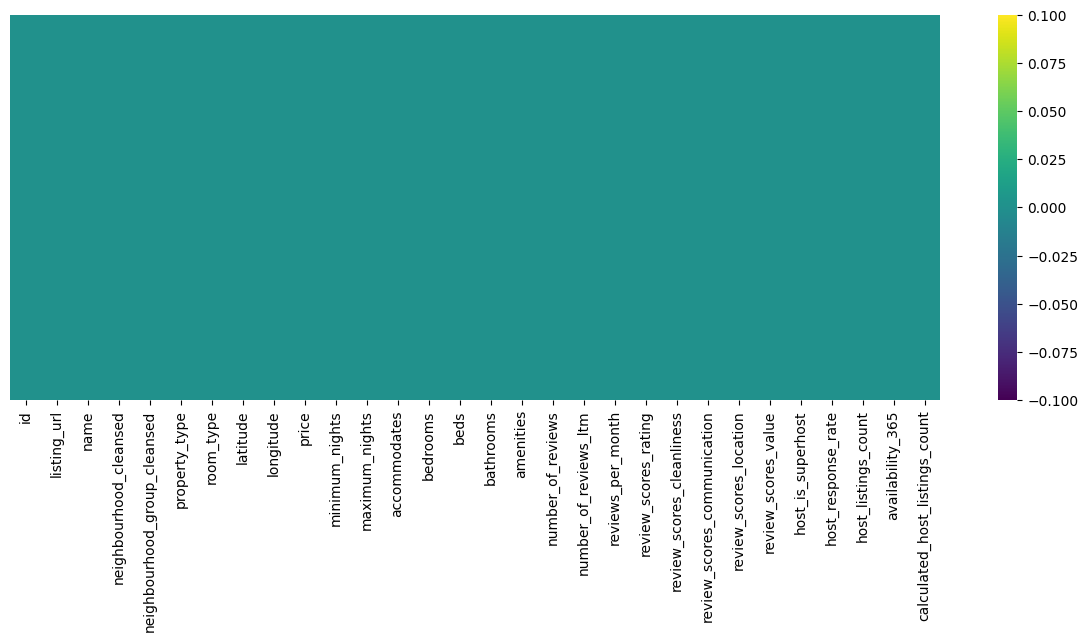

In [107]:
# Comprobamos con mapa de calor que se ha llevado correctamente el KNN
plt.figure(figsize=(15, 5))
sns.heatmap(df_listings.isnull(), yticklabels=False, cbar=True, cmap="viridis")

Podemos ver que ya no tenemos valores nulos en ninguno de los dataframe

### **GUARDAMOS DATAFRAMES LIMPIOS**
Ahora que tenemos los dataset limpios, vamos a guardarlos en su CSV para poder analizar los outliers en el cuarderno 2

In [108]:
df_calendar.isnull().sum()

listing_id        0
date              0
available         0
price             0
minimum_nights    0
maximum_nights    0
dtype: int64

In [109]:
import os 

folder_name = '2. data_limpia'
base_path = '/Users/juliobrionesmorales/Documents/GitHub/Airbnb_Barcelona/data/2. data_sin_nulos'
folder_path = os.path.join(base_path, folder_name)

# Crea la carpeta si no existe
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Guarda cada DataFrame como un archivo CSV en la carpeta específica
df_reviews.to_csv(os.path.join(folder_path, 'df_reviews.csv'), index=False)

print(f"Archivos CSV guardados en la carpeta: {folder_path}")

Archivos CSV guardados en la carpeta: /Users/juliobrionesmorales/Documents/GitHub/Airbnb_Barcelona/data/2. data_sin_nulos/2. data_limpia


In [42]:

"""
import os
# Definimos la carpeta específica donde vamos a guardar los DataFrames sin valores nulos
folder_name = '2. data_limpia'
base_path = '/Users/juliobrionesmorales/Documents/GitHub/Airbnb_Barcelona/data/2. data_sin_nulos'
folder_path = os.path.join(base_path, folder_name)

# Crea la carpeta si no existe
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Guarda cada DataFrame como un archivo CSV en la carpeta específica
#df_calendar.to_csv(os.path.join(folder_path, 'df_calendar.csv'), index=False)
df_listings.to_csv(os.path.join(folder_path, 'df_listings.csv'), index=False)
#df_reviews.to_csv(os.path.join(folder_path, 'df_reviews.csv'), index=False)

#print(f"Archivos CSV guardados en la carpeta: {folder_path}")
""" 

# investigar para poder guardar los archivos en pickle y feather 

# df.to_peakle()

In [66]:
""" 
# forma de guardar los archivos en feather
import os
import feather

# Definimos la carpeta específica donde vamos a guardar los DataFrames sin valores nulos
folder_name = '2. data_limpia'
base_path = '/Users/juliobrionesmorales/Documents/GitHub/Airbnb_Barcelona/data/2. data_sin_nulos'
folder_path = os.path.join(base_path, folder_name)

# Crea la carpeta si no existe
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Guarda cada DataFrame como un archivo Feather en la carpeta específica
feather.write_dataframe(df_calendar, os.path.join(folder_path, 'df_calendar.feather'))
feather.write_dataframe(df_listings, os.path.join(folder_path, 'df_listings.feather'))
feather.write_dataframe(df_reviews, os.path.join(folder_path, 'df_reviews.feather'))

print(f"Archivos Feather guardados en la carpeta: {folder_path}")
"""

Archivos Feather guardados en la carpeta: /Users/juliobrionesmorales/Documents/GitHub/Airbnb_Barcelona/data/2. data_sin_nulos/2. data_limpia


Solo tenemos 3 variables numéricas, y vamos a ver si tenemos variables tenemos outliers y ver si podemos arreglarlos